### This is an experiment following the instructions given in the YouTube video "Linear Regression Algorithm in Python from Scratch" by DataQuest. This is the link to the video: https://www.youtube.com/watch?v=mpuKSovz9xM&t=4s. There is also a GitHub page: https://github.com/dataquestio/project-walkthroughs/tree/master/ridge_regression.

Ridge regression is a lot like linear regression, but there is a penalty added to this equation. This penalty is λ (lambda). As the penalty λ increases, then the y-intercept b<sub>0</sub> stays constant and the coefficient b<sub>1</sub> goes to 0.  
  
λ helps with collinearity. Hence, ridge regression works well with multicollinearity issues in the data. Multicollinearity is when two or more independent variables in a model are correlated. Multicollinearity typically leads to less reliable models, so it's always good to check the data for this. λ helps with collinearity by penalizing the coefficients.

Goal for prediction: Given how many athletes are entered into the Olympics for a country, can we predict how many medals they'll win.  
  
We will use two predictors, or variables, in this model. We will use the number of athletes entered as well as the number of events each country enters their athletes in.


In [13]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
data_folder = pathlib.Path.cwd()/'data'
data_folder

PosixPath('/Users/kerstinwolf/DS Projects/GitHub/Experiments/data')

In [3]:
teams = pd.read_csv(data_folder/'teams.csv')
teams

,team,year,athletes,events,age,height,weight,prev_medals,medals
0,AFG,1964,8,8,22.0,161.0,64.2,0.0,0
1,AFG,1968,5,5,23.2,170.2,70.0,0.0,0
2,AFG,1972,8,8,29.0,168.3,63.8,0.0,0
3,AFG,1980,11,11,23.6,168.4,63.2,0.0,0
4,AFG,2004,5,5,18.6,170.8,64.8,0.0,0
...,...,...,...,...,...,...,...,...,...
2009,ZIM,2000,26,19,25.0,179.0,71.1,0.0,0
2010,ZIM,2004,14,11,25.1,177.8,70.5,0.0,3
2011,ZIM,2008,16,15,26.1,171.9,63.7,3.0,4
2012,ZIM,2012,9,8,27.3,174.4,65.2,4.0,0


Text(0, 0.5, 'Events')

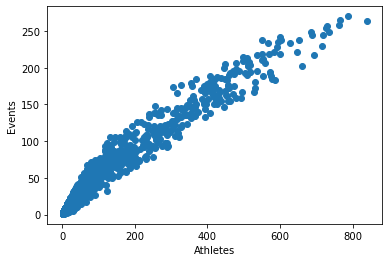

In [4]:
# check for colinearity - very collinear (highly correlated)
plt.scatter(teams[['athletes']], teams[['events']])
plt.xlabel('Athletes')
plt.ylabel('Events')

Experiment time! Ignoring the colinearity for now, let's see what would happen if I just did a linear regression with these variables.

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(teams[['athletes', 'events']], teams[['medals']])

LinearRegression()

In [9]:
lr.intercept_

array([0.18800573])

In [11]:
lr.coef_

array([[ 0.48837038, -0.71791314]])

As can be seen above, the coefficient for athletes (b<sub>1</sub>) is about 0.488, and the coefficient for events (b<sub>2</sub>) is about -0.718. This means that for every athlete entered into the Olympics, we expect 0.488 medals. But for every event a country enters in, it is expected that they will lose 0.718 medals. This doesn't make much sense! This is because athletes and events are highly correlated (as seen earlier). Linear regressions can't handle colinearity well. The model will look great when training, but when you go to predict later on, the data won't fit at all. That's where ridge regression comes in! That ridge penality λ will keep the y-intercept the same and shift the coefficients (b<sub>1</sub>, b<sub>2</sub>, etc) towards 0. Of course, it is important to not increase λ too much or else you run the risk of making the coefficients too small and underfitting the data. As the person in the YouTube video said, "the ridge penalty reduces overfitting when predictor variables are collinear."

For more details about the math (linear algebra) behind ridge regression, watch the YouTube video linked at the top. Since the formula is very similar to a linear regression, I'd also recommend watching the linear regression video (https://www.youtube.com/watch?v=z2hpinQggNM) first to understand the math that led to this point.

This is a formula for linear regression (I know it looks totally different than what I normally think of for linear regression. This is why you need to watch the linear regression video!): <br/>
B = (X<sup>T</sup> X)<sup>-1</sup> X<sup>T</sup> y <br/>
X<sup>T</sup> is X transposed (basically, dataframe of coefficients pushed over so the index is the column headers and vice versa.  
The -1 means that it's inverse  
  
Ridge regression formula: <br/>
(X<sup>T</sup> X + λ I)<sup>-1</sup> X<sup>T</sup> y <br/>
λ is the ridge regression penalty  
I is the identity matrix (see linear regression video: https://www.youtube.com/watch?v=z2hpinQggNM). I should note that this I is not a completely true identity matrix since we don't want to penalize the y-intercept. This is discussed in the ridge regression video.  
  
Before using this formula on the data, you first need to standardize the daata so that the standard deviation is 1 and the mean is 0. You do this by subtracting the mean from each column and dividing each column by the standard deviation. We do this because we want the λ to be about on the same scale as the variables.

Ridge regression is good for reducing overfitting (in the case of collinearity) and enables matrix inversion (when one column is a multple of another column).

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# creating the train and test set
# test set is 20% of the entire dataset
# random_state is setting the random seed
train, test = train_test_split(teams, test_size = 0.2, random_state = 1)

In [20]:
predictors = ['athletes', 'events']
target = 'medals'

In [21]:
# the .cpoy() is used to avoid the pandas Setting with Copy Warning (https://towardsdatascience.com/3-solutions-for-the-setting-with-copy-warning-of-python-pandas-dfe15d62de08)
X = train[predictors].copy()
X

,athletes,events
1322,6,6
1872,119,80
953,4,4
1117,2,2
1993,43,25
...,...,...
1791,40,25
1096,36,23
1932,719,245
235,13,11


In [23]:
y = train[[target]].copy()
y

,medals
1322,0
1872,5
953,0
1117,0
1993,0
...,...
1791,1
1096,1
1932,264
235,0


In [27]:
# Get info to use for standardizing the data
x_mean = X.mean()
x_std = X.std()

In [28]:
x_mean

athletes    74.409063
events      35.990068
dtype: float64

In [29]:
x_std

athletes    127.250043
events       48.978737
dtype: float64

In [30]:
# Standardize the data
X = (X - x_mean) / x_std

In [31]:
# When the data is standardized, you should notice that the mean is basically 0 and standard deviation should be 1.
X.describe()

,athletes,events
count,1.611000e+03,1.611000e+03
mean,-1.338677e-17,1.287852e-18
std,1.000000e+00,1.000000e+00
min,-5.768883e-01,-7.143930e-01
25%,-5.297371e-01,-6.123079e-01
50%,-4.197174e-01,-4.489717e-01
75%,-2.679027e-02,1.839560e-01
max,6.008571e+00,4.634867e+00


In [32]:
# Add the intercept column
X['intercept'] = 1
X = X[['intercept'] + predictors]
X

,intercept,athletes,events
1322,1,-0.537596,-0.612308
1872,1,0.350420,0.898552
953,1,-0.553313,-0.653142
1117,1,-0.569030,-0.693976
1993,1,-0.246829,-0.224384
...,...,...,...
1791,1,-0.270405,-0.224384
1096,1,-0.301839,-0.265219
1932,1,5.065546,4.267361
235,1,-0.482586,-0.510223


In [34]:
X.T

,1322,1872,953,1117,1993,385,1287,1831,0,1159,...,960,847,1669,715,905,1791,1096,1932,235,1061
intercept,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
athletes,-0.537596,0.350420,-0.553313,-0.569030,-0.246829,-0.482586,-0.537596,0.138239,-0.521879,-0.152527,...,-0.199678,-0.160386,-0.529737,-0.529737,-0.341132,-0.270405,-0.301839,5.065546,-0.482586,-0.191820
events,-0.612308,0.898552,-0.653142,-0.693976,-0.224384,-0.571474,-0.612308,0.102288,-0.571474,-0.163133,...,-0.285636,-0.101882,-0.612308,-0.591891,-0.367304,-0.224384,-0.265219,4.267361,-0.510223,0.041037


In [36]:
# lambda (λ) will be known as alpha in the code since lambda is a keyword in python to define an anonymous function, so we can't use it as a variable.
alpha = 2
I = np.identity(X.shape[1])

In [37]:
I

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [38]:
I[0][0] = 0
I

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [39]:
penalty = alpha * I
penalty

array([[0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [40]:
# the formula that will give the ridge regression coefficients
# @ is matrix multiplication
# 0 = y-intercept, 1 = b1 (athletes), 2 = b2 (events)
B = np.linalg.inv(X.T @ X + penalty) @ X.T @ y
B

,medals
0,10.691496
1,61.857734
2,-34.632920


In [42]:
B.index = ['intercept', 'athletes', 'events']
B

,medals
intercept,10.691496
athletes,61.857734
events,-34.632920


In [44]:
# Apply to test data
# scale the data. Use mean and std from training set since you won't usually know the data you'll be using to make predictions on when you're doing the training - According to DattQuest video on ridge regression
test_X = test[predictors]
test_X = (test_X - x_mean) / x_std
test_X['intercept'] = 1
test_X = test_X[['intercept'] + predictors]
test_X

,intercept,athletes,events
309,1,-0.553313,-0.653142
285,1,0.594035,1.000637
919,1,-0.144668,0.102288
120,1,0.146098,0.531045
585,1,-0.301839,-0.122299
...,...,...,...
541,1,-0.380425,-0.408138
1863,1,-0.191820,0.143122
622,1,-0.058224,0.388126
1070,1,-0.569030,-0.693976


In [46]:
# this is the number of medals we predict each country to win
predictions = test_X @ B
predictions

,medals
309,-0.914959
285,12.782156
919,-1.799893
120,1.337116
585,-3.744014
...,...
541,1.294285
1863,-6.130765
622,-6.352080
1070,-0.472980


Now, let's compare the results to scikit-learn's ridge regression.

In [47]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = alpha)

In [48]:
# Don't need to pass in the itercept term in since scikit-learn will add it in on its own
ridge.fit(X[predictors], y)

Ridge(alpha=2)

As can be seen below, the y-intercept and coefficients here match the model we did earlier without scikit-learn!

In [52]:
ridge.intercept_

array([10.69149597])

In [53]:
ridge.coef_

array([[ 61.85773366, -34.63292036]])

In [54]:
# check predictions
sklearn_predictions = ridge.predict(test_X[predictors])

When comparing the original predictions to the scikit-learn predictions, we can see that they are practically identical since the results of subtracting the two results below are extremely close to 0.

In [55]:
# compare the predictions from both ridge regression models
predictions - sklearn_predictions

,medals
309,3.874678e-14
285,-1.385558e-13
919,-9.325873e-14
120,-1.405542e-13
585,-7.105427e-14
...,...
541,1.354472e-14
1863,-1.323386e-13
622,-1.740830e-13
1070,4.407585e-14


Determine how to find the optimal alpha (aka lambda, λ) parameter

In [85]:
# a lot of this is the same code from above
def ridge_fit(train, predictors, target, alpha):
    X = train[predictors].copy()
    y = train[[target]].copy()
    
    x_mean = X.mean()
    x_std = X.std()
    
    X = (X - x_mean) / x_std
    X["intercept"] = 1
    X = X[["intercept"] + predictors]
    
    penalty = alpha * np.identity(X.shape[1])
    penalty[0][0] = 0
    
    B = np.linalg.inv(X.T @ X + penalty) @ X.T @ y
    B.index = ["intercept", "athletes", "events"]
    return B, x_mean, x_std

In [86]:
def ridge_predict(test, predictors, x_mean, x_std, B):
    test_X = test[predictors]
    test_X = (test_X - x_mean) / x_std
    test_X["intercept"] = 1
    test_X = test_X[["intercept"] + predictors]

    predictions = test_X @ B
    return predictions

In [87]:
from sklearn.metrics import mean_absolute_error

In [88]:
alphas = [10 ** i for i in range(-2,4)]
alphas

[0.01, 0.1, 1, 10, 100, 1000]

In [91]:
errors = []
for alpha in alphas:
    B, x_mean, x_std = ridge_fit(train, predictors, target, alpha)
    predictions = ridge_predict(test, predictors, x_mean, x_std, B)
    errors.append(mean_absolute_error(test[target], predictions))

Look at the errors and alphas (lambdas) below. The error for an alpha of 0.01 is 6.3096; for an alpha of 0.1, the error is 6.3060; etc. The alpha of 10 gives the lowest MAE (mean absolute error), so it is the best. 

In [92]:
errors

[6.3096408301611175,
 6.30604433195291,
 6.2722833764316075,
 6.114051204717743,
 7.156811236590455,
 6.9780545895757315]

In [90]:
alphas

[0.01, 0.1, 1, 10, 100, 1000]